In [1]:
using LinearAlgebra, Statistics, Compat, Plots, Distributions

┌ Info: Recompiling stale cache file /home/aktersnurra/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.


In [2]:
gr(fmt=:png) # Plot setup

Plots.GRBackend()

In [3]:
# Set up the priors
Σ = [0.4 0.3
     0.3 0.45] # Covariance of the distribution of where the missile is. 

x̂ = [0.2, -0.2] # This is the mean of the distributions of where the missile is.

2-element Array{Float64,1}:
  0.2
 -0.2

In [4]:
# sensor report the current location of the missile at
y = [2.3, -1.9]

2-element Array{Float64,1}:
  2.3
 -1.9

In [5]:
initial_dist = MvNormal(x̂, Σ)

FullNormal(
dim: 2
μ: [0.2, -0.2]
Σ: [0.4 0.3; 0.3 0.45]
)


In [6]:
two_args_to_pdf(dist) = (x, y) -> pdf(dist, [x, y]) # returns a function to be plotted

two_args_to_pdf (generic function with 1 method)

In [7]:
# Plotting objects
x_grid = range(-1.5, 2.9, length=100)
y_grid = range(-3.1, 1.7, length=100)

-3.1:0.048484848484848485:1.7

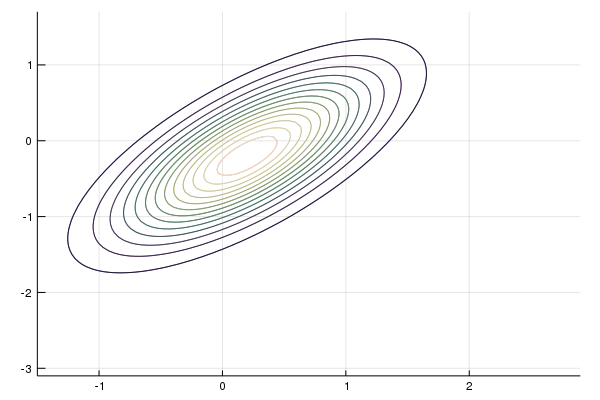

In [8]:
# First plot
contour(x_grid, y_grid, two_args_to_pdf(initial_dist), fill=false, color=:lighttest, cbar=false)
contour!(x_grid, y_grid, two_args_to_pdf(initial_dist), fill=false, lw=1, color=:grays, cbar=false)

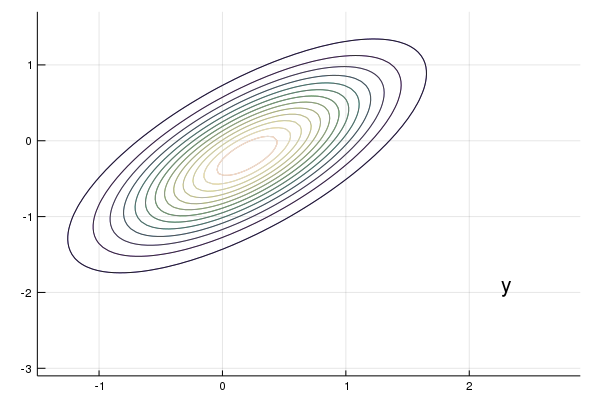

In [9]:
annotate!(y[1], y[2], "y", color=:black)

# Filtering Step

We should interpret the output from the sensor not as y = x, but as 

\begin{equation}
y = Gx + ν\quad (3)
\end{equation}

where $\nu ~ N(0, R)$.

Here G and R are 2×2 matrices with R being positive definite. Both are assumed known, and the noise term ν is assumed to be independent of x.

How then should we combine our prior $p(x) = \mathcal{N}(\hat{x}, \Sigma)$ and this new information y to improve our understanding of the location of the missile?

As you may have guessed, the answer is to use Bayes' theorem, which tells us to update our prior $p(x)$ to $p(x|y)$ via
\begin{equation}
    p(x|y) = \frac{p(y|x)p(x)}{p(y)}
\end{equation}
where $p(y) = \int p(y|x)p(x)dx$

In solving for $p(x|y)$, we observe that


* $p(x) = N(x, \Sigma)$

* In view of (3), the conditional density $p(x|y)$ is $\mathcal{N}(Gx, R)$

* $p(y)$ does not depend on $x$, and enters into the calculations only as a normalizing constant

Because we are in a linear and Gaussian framework, the updated density can be computed by calculating population linear regression.

In particular, the solution is known to be 

\begin{equation}
p(x|y) = \mathcal{N}(\hat{x}^{F}, \Sigma^{F})
\end{equation}

where 

\begin{equation}
x^{F} := \hat{x} + \Sigma G^{\top}(G\Sigma G^\top + R)^{-1} \text{ and } \Sigma^{F} := \Sigma - \Sigma G^\top(G \Sigma G^\top R)^{-1} G \Sigma
\end{equation}


Here $\Sigma G^\top(G \Sigma G^\top R)^{-1}$ us the matrix of the population regression coeffiecents of the hidden object $x - \hat{x}$ on the suprise $y - G \hat{x}$.

This new density $p(x|y)\mathcal{N}(\hat{x}^{F}, \Sigma^{F})$ is shown in the next figure via contour lines and the color map.

The original density is left in as contour lines for comparison.

In [10]:
# Define G and R from the y = Gx + N(0, R)
G = I
R = 0.5 .* Σ


# Define A and Q
A = [1.2 0
     0  -0.2]
Q = 0.3Σ

2×2 Array{Float64,2}:
 0.12  0.09 
 0.09  0.135

In [11]:
# Define posterior objects
M = Σ * G' * inv(G * Σ * G' + R)
x̂_F = x̂ + M * (y - G * x̂)
Σ_F = Σ - M * G * Σ

2×2 Array{Float64,2}:
 0.133333  0.1 
 0.1       0.15

In [12]:
updated_dist = MvNormal(x̂_F, Symmetric(Σ_F))

FullNormal(
dim: 2
μ: [1.6, -1.33333]
Σ: [0.133333 0.1; 0.1 0.15]
)


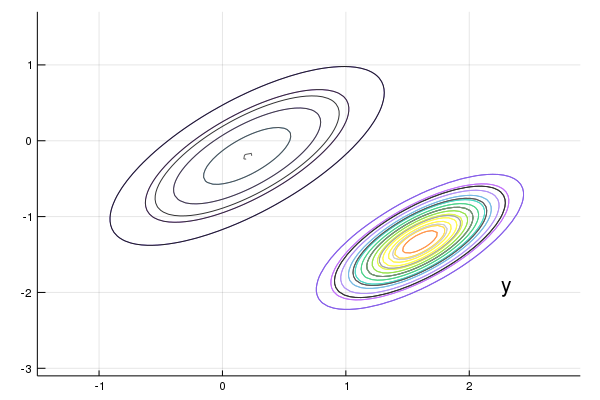

In [15]:
contour!(x_grid, y_grid, two_args_to_pdf(updated_dist), fill=false, color=:lighttest, cbar=false)
contour!(x_grid, y_grid, two_args_to_pdf(updated_dist), fill=false, levels=7, color=:grays, cbar=false)
contour!(x_grid, y_grid, two_args_to_pdf(initial_dist), fill=false, levels=7, lw=1, color=:grays, cbar=false)

# Forecasting step

We have obtained probabilities for the current location of the state (missile) given a prior and current information. This is called filtering rather than forcasting, because we are filtering out the noise rather than looking into the future.

* $p(x|y) = \mathcal{N}(\hat{x}, \Sigma^F)$

But now let's suppose that we are given another task; to predict the location of the missile after one unit of time has elapsed.

To do this we need a model of how the state evolves.

Let's suppose that we have one, and that it is linear and Gaussian. In particular,

\begin{equation}
x_{t+1} = Ax_t + w_{t+1} \quad (5)
\end{equation}

where $w_t \sim \mathcal{N}(0, Q)$

Our aim is to combine this law of motion and our current distribution $p(x|y) = \mathcal{N}(\hat{x}^F, \Sigma^F)$ to come up with a new predictive distribution for the location in one unit of time.

In view of $(5)$, all we have to do is to introduce a random vector $x^F \sim \mathcal{N}\hat{x}^F, \Sigma^F)$ and work out hte distribution of $Ax^F + w$ where $w$ is independet of $x^F$ and has distribution $\mathcal{N}(0, Q)$.

Since linear combinations of Gaussians are Gaussian, $Ax^F + w$ is a Gaussian. Elementary calculations and the expression in $(4)$ tell us that

\begin{equation}
\mathbb{E}[Ax^F + w] = A\mathbb{E}[x^F] + \mathbb{E}[w] = A\hat{x}^F = A\hat{x} + A \Sigma G^\top (G \Sigma G^\top + R)^{-1}(y - G\hat{x})
\end{equation}

and that 

\begin{equation}
\mathrm{Var}[Ax^F + w] = A\mathrm{Var}[x^F]A^\top + Q = A \Sigma^F A^\top + Q = A \Sigma A^\top + A \Sigma G^\top (G \Sigma G^\top + R)^{-1}G \Sigma A^\top + Q 
\end{equation}

The matrix $A \Sigma G^\top (G \Sigma G^\top + R)^{-1}$ is often written as $\mathrm{K}_\Sigma$ and called the *Kalman gain*. 

* The subscript $\Sigma$ has been added to remind us that $\mathrm{K}_\Sigma$ depends on $\Sigma$ and not on $y$ or $\hat{x}$

Using this notation, we can summerize our results as follows:

* Our updated prediction is the density $\mathcal{N}(\hat{x}_{new}, \Sigma_{new})$ where
\begin{align*} 
\hat{x}_{new} &:= A\hat{x} + \mathrm{K}_\Sigma(y-G\hat{x})\\ 
\Sigma_{new} &:= A \Sigma A^\top - \mathrm{K}_\Sigma G \Sigma  A^\top + Q
\end{align*}

* The density $p_{new}(x) = \mathcal{N}(\hat{x}_{new}, \Sigma{new})$ is called the _predictive_ _distribution_.


The predictive distribution is the new density shown in the following figure, where the update has used parameters:

\begin{align*} 
A & = \begin{pmatrix} 1.2 & 0.0 \\ 0.0 & -0.2 \end{pmatrix}\\ 
Q & = 0.3 \cdot \Sigma
\end{align*}

In [18]:
# get the new predictive distribution
x̂_new = A * x̂_F
Σ_new = A * Σ_F * A' + Q

predict_dist = MvNormal(x̂_new, Symmetric(Σ_new))

FullNormal(
dim: 2
μ: [1.92, 0.266667]
Σ: [0.312 0.066; 0.066 0.141]
)


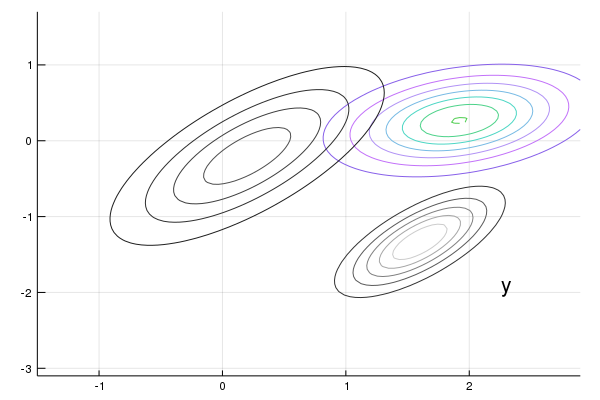

In [20]:
# plot density 3
contour(x_grid, y_grid, two_args_to_pdf(predict_dist), fill=false, lw=1, color=:lighttest, cbar=false)
contour!(x_grid, y_grid, two_args_to_pdf(initial_dist), color=:grays, cbar=false)
contour!(x_grid, y_grid, two_args_to_pdf(updated_dist), fill=false, levels=7, color=:grays, cbar=false)
annotate!(y[1], y[2], "y", color=:black)